In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from importlib import reload
import matplotlib.pyplot as plt


In [2]:
import sys
sys.path.append("/home/kim2712/Desktop/research/conformal_tree/")

In [3]:
from conformal_tree._utils.tree_utils import tree_membership,tree_plotter
from conformal_tree._utils.conformal_utils import conf_plotter

from conformal_tree._data import sin_simul as data_gen
opt1=1
opt2=1

DATA = data_gen.get_data(n0=200,
                     n=400,seed=1, 
                     x_option=opt1,
                     noise_option=opt2)
(x_train,y_train),(x_calib,y_calib),(x_test, y_test) = DATA

from conformal_tree._nets import network_toy as nt
reload(nt)

<module 'conformal_tree._nets.network_toy' from '/home/kim2712/Desktop/research/conformal_tree/conformal_tree/_nets/network_toy.py'>

In [4]:
import torch
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


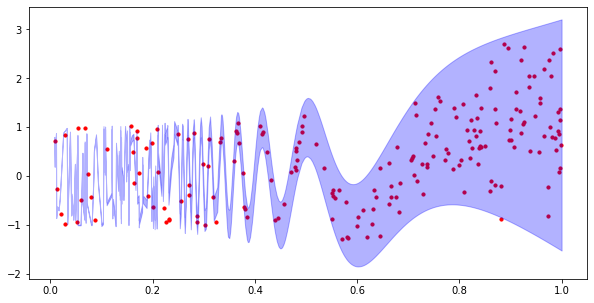

In [5]:
from scipy.stats import norm
q_upper = 0.9
y_true_low = data_gen.cond_exp(x_test, option=opt1) - norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test, option=opt2))
y_true_up =  data_gen.cond_exp(x_test, option=opt1) + norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test, option=opt2))
 
conf_plotter(x_test[:,0], y_true_low, y_true_up,test_data=(x_train[:,0],y_train)) 
#conf_plotter(x_test[:,0], y_true_low, y_true_up,test_data=(x_test[:,0],y_test)) 


In [6]:
# 0. I need a machine learning model
# 1. I need conformal method
# 2. I need a CART fitting method - but assume that I have
# 3. I need to code my algorithm

In [7]:
X_train, Y_train = torch.from_numpy(x_train).to(DEVICE).float(),torch.from_numpy(y_train).to(DEVICE)
X_calib, Y_calib = torch.from_numpy(x_calib).to(DEVICE).float(),torch.from_numpy(y_calib).to(DEVICE)

In [8]:
net = nt.MLP(input_dim=1, out_dim=1, device = DEVICE, factor=128)

In [9]:
criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)#, weight_decay=0.999)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)

In [10]:
for it in range(10000):
    optimizer.zero_grad()
    
    Y_pred = net(X_train)
    loss = (Y_train.view(-1)-Y_pred.view(-1)).pow(2).mean()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if it % 1000 ==0: 
        print(loss)

tensor(0.9455, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.4178, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.4091, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.4012, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3978, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3965, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3956, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3953, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3952, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3952, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [11]:
import pathlib
path = "./trained_nets"
pathlib.Path(path).mkdir(parents=True, exist_ok=True)
torch.save(net.state_dict(),  path+F"/sin_opt{opt1}{opt2}.net")

import pickle
cache = {"data":DATA, "opt1":opt1, "opt2":opt2}
with open(path+F"/sin_opt{opt1}{opt2}.dat", 'wb') as file:
    pickle.dump(cache, file)
    
#with open(path, 'rb') as f:
#    self.cache = pickle.load(f)

        

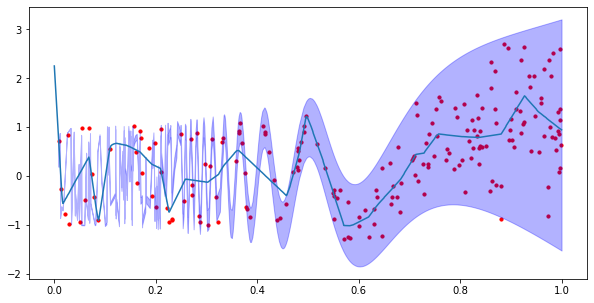

In [12]:
from scipy.stats import norm

y_true_low = data_gen.cond_exp(x_test,option=opt1) - norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
y_true_up =  data_gen.cond_exp(x_test,option=opt1) + norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
 
conf_plotter(x_test[:,0], y_true_low, y_true_up,
             test_data=(x_train[:,0],y_train), model=net) 

<BarContainer object of 200 artists>

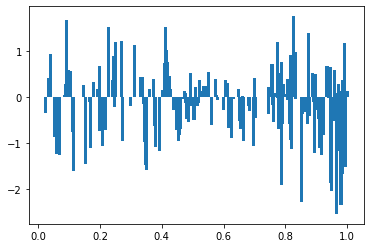

In [13]:
## Error calculation
with torch.no_grad():
    out_calib = net(X_calib).cpu().view(-1)
error = (Y_calib.cpu().view(-1) - out_calib.view(-1)).numpy()
plt.bar(x_calib[:,0],error, width=0.01)



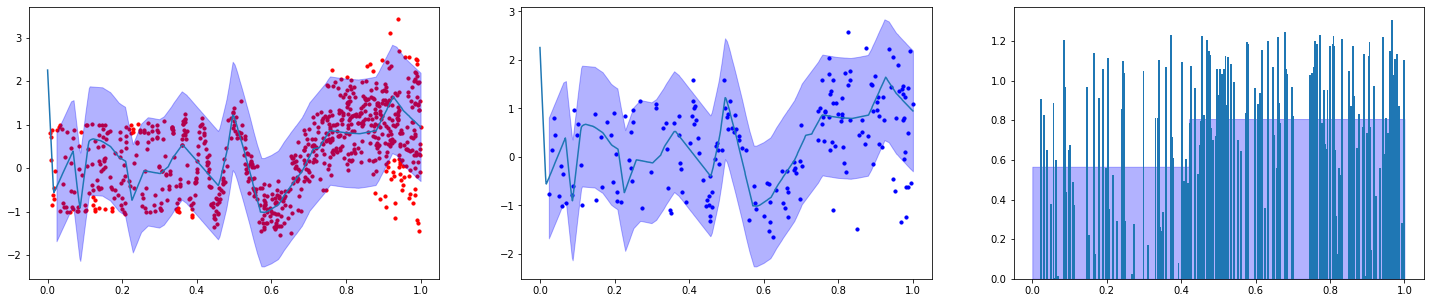

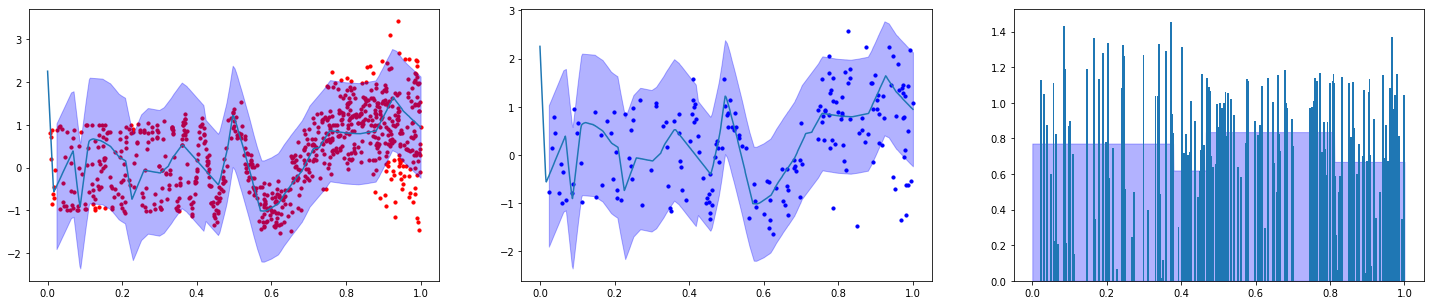

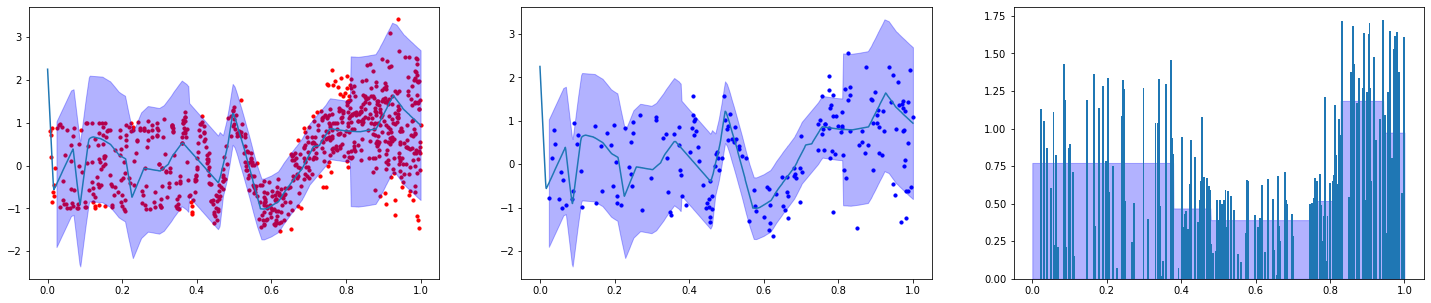

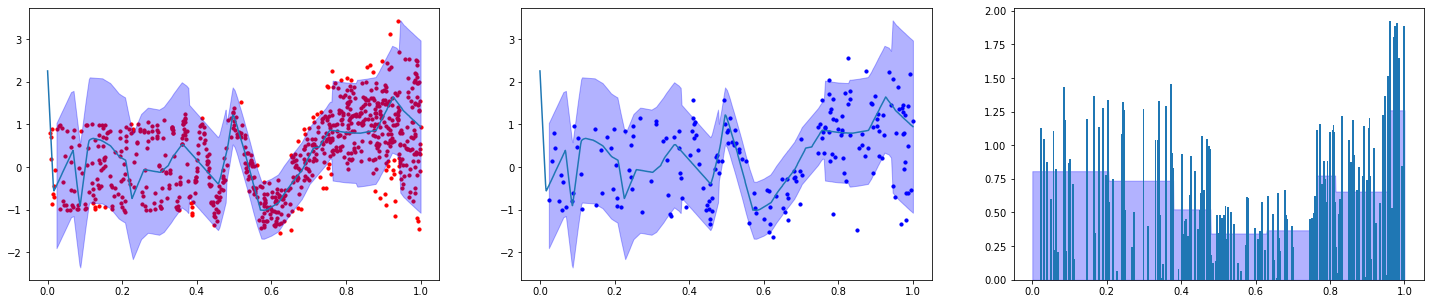

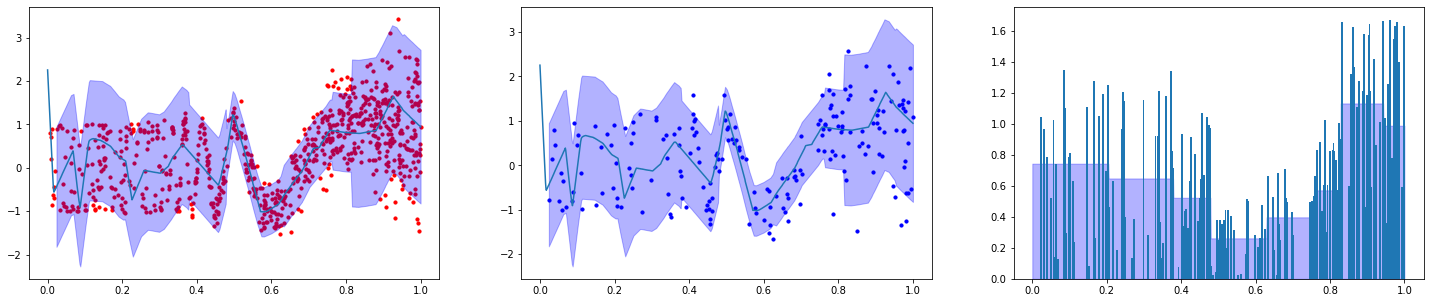

In [14]:
tree_model, membership = tree_membership(x_calib, x_calib[:,0]*0)
bin_idx = np.unique(membership)

for it in range(5):
    fig, axis = plt.subplots(1, 3, figsize=(25,5))
    
    y_low, y_up = out_calib,out_calib
    
    idx_counter = 0
    indices = 0*y_low
    
    for idx in bin_idx:
        
        idx_counter +=1
        indices[membership==idx] = idx_counter
        
        x_subset = x_calib[membership==idx]
        error_subset = error[membership==idx]
        C = np.quantile(np.abs(error_subset), 0.90)
        y_low -= C* (membership==idx)
        y_up  += C* (membership==idx)


    #conf_plotter(x_calib[:,0],  y_low, y_up,test_data=(x_test,y_test),model=net, ax=axis[0]) #y_cal = y_calib
    conf_plotter(x_calib[:,0],  y_low, y_up,y_cal =y_calib,model=net, ax=axis[1]) #y_cal = y_calib
    
    

    c_gap = torch.minimum((y_low-y_calib).abs(), (y_up-y_calib).abs())
    tree_model, membership = tree_membership(x_calib, c_gap, max_depth=20,
                                             max_leaf_nodes=(it+1)*2,
                                             min_samples_leaf=20)
    bin_idx = np.unique(membership)
    
    tree_plotter(tree_model,x_calib[:,0], c_gap,ax=axis[2])
    
    conf_plotter(x_calib[:,0],  y_low, y_up,
                 test_data=(x_test[:,0],y_test),model=net, ax=axis[0]) #y_cal = y_calib
    
    plt.show()
    